## Eurofab model training

In [1]:
import glob

import geopandas as gpd
import matplotlib.pyplot as plt
import numba
import numpy as np
import pandas as pd
from libpysal.graph import read_parquet
from sklearn.preprocessing import PowerTransformer, RobustScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from core.utils import used_keys

from palettable.colorbrewer.qualitative import Set3_12
from sklearn.metrics import davies_bouldin_score, f1_score

from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_moons
from sklearn import model_selection
from sklearn.metrics import accuracy_score, balanced_accuracy_score, make_scorer

In [2]:
v = 'v3'
sample_size = 500_000


mapping_level = 4

train_test_iteration = 4

Read the training data, groups and labels

In [3]:
%%time
X_train = pd.read_parquet(f'/data/uscuni-eurofab-overture/processed_data/train_test_data/training_data{train_test_iteration}.pq')
y = pd.read_parquet(f'/data/uscuni-eurofab-overture/processed_data/train_test_data/training_labels{train_test_iteration}.pq')

CPU times: user 1min 46s, sys: 1min 16s, total: 3min 3s
Wall time: 31.8 s


In [4]:
X_train.shape

(61206395, 144)

Map the labels to the appropriate aggregation level

In [5]:
cluster_mapping = pd.read_parquet(f'/data/uscuni-ulce/processed_data/clusters/cluster_mapping_{v}.pq')

if mapping_level == 3:
    level_cut = cluster_mapping[3].astype(str)
    level_cut[level_cut == '2'] = '8'
    cluster_names = {
    '1': 'Central Urban Developments',
     '3': 'Dense Urban Developments',
     '4': 'Street-aligned Developments',
     '5': 'Sparse Rural Development',
     '6': 'Linear Road Network Developments',
     '7': 'Sparse Road Network Developments',
     '8': 'Large Scale Developments'
    }

elif mapping_level == 4:
    # # assign outliers to the industrial cluster
    level_cut = cluster_mapping[4].astype(str)
    level_cut[level_cut == '3'] = '15'
    level_cut[level_cut == '4'] = '15'
    level_cut[level_cut == '10'] = '15'
    cluster_names = {'1': 'Dense Connected Developments',
     '2': 'Large Interconnected Blocks',
     '3': 'Extensive Courtyard Complexes',
     '4': 'Massive Connected Aggregations',
     '5': 'Dense Standalone Buildings',
     '6': 'Compact Development',
     '7': 'Cul-de-Sac Layout',
     '8': 'Aligned Winding Streets',
     '9': 'Sparse Rural Development',
     '10': 'Large Wide-Spaced Complexes',
     '11': 'Dispersed Linear Development',
     '12': 'Linear Development',
     '13': 'Sparse Open Layout',
     '14': 'Sparse Road-Linked Development',
     '15': 'Large Utilitarian Development',
     '16': 'Extensive Wide-Spaced Developments'}

In [6]:
has_building = ~y.index.str.split('_').str[-1].str.startswith('-')

X_train = X_train[has_building]
y = y[has_building]

assert y.final_without_noise.isna().sum() == 0
assert (y.final_without_noise == -1).sum() == 0
assert (X_train.index == y.index).all()

y.shape

(61206395, 1)

In [7]:
%%time
y['final_without_noise'] = y['final_without_noise'].map(level_cut.to_dict())
y['final_without_noise'].value_counts()

CPU times: user 1.57 s, sys: 206 ms, total: 1.78 s
Wall time: 1.78 s


final_without_noise
8     9198295
1     8991554
13    8123237
6     8085547
14    6712600
7     6344274
5     4844374
9     3045053
12    2331757
2      999963
15     869190
16     841829
11     818722
Name: count, dtype: int64

Undersample and Predict only building classification, so drop empty ETCs.

In [8]:
%%time

if sample_size > y['final_without_noise'].value_counts().iloc[-1]:
    sample_size = y['final_without_noise'].value_counts().iloc[-1] - 1_000

np.random.seed(123)
train_indices = []
classes = y.final_without_noise.unique()
has_building = ~y.index.str.split('_').str[-1].str.startswith('-')

for cluster in classes:
    random_indices = np.random.choice(np.where((y.final_without_noise == cluster) & (has_building))[0], sample_size, replace=False, )
    train_indices.append(random_indices)

train_indices = np.concat(train_indices)

CPU times: user 1min 8s, sys: 2.8 s, total: 1min 11s
Wall time: 1min 11s


In [9]:
X_train = X_train.iloc[train_indices]
y = y.iloc[train_indices]

assert y.final_without_noise.isna().sum() == 0

In [10]:
X_resampled, y_resampled = X_train, y.final_without_noise

In [11]:
if 'source' in X_resampled.columns:
    # we can do this because of random forest splitting
    source_factorizer = X_resampled['source'].factorize()
    X_resampled['source'] = source_factorizer[0]

In [12]:
y_resampled.value_counts()

final_without_noise
6     500000
1     500000
7     500000
8     500000
14    500000
2     500000
15    500000
13    500000
5     500000
16    500000
9     500000
12    500000
11    500000
Name: count, dtype: int64

#### Random Forest

In [14]:
# %%time

# from sklearn.ensemble import RandomForestClassifier

# best_model = RandomForestClassifier(random_state=123, n_jobs=-1, 
#                                      oob_score=True,
#                                      n_estimators=300, 
#                                      # max_samples=1_000_000,
#                                      max_features=.5,
#                                      min_samples_leaf=2,
#                                      verbose=1
# )

# best_model.fit(X_resampled, y_resampled)

# best_model.oob_score_, best_model.score(X_resampled, y_resampled)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed: 74.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 138.2min finished


CPU times: user 2d 5h 40min 58s, sys: 2min 3s, total: 2d 5h 43min 2s
Wall time: 2h 22min 45s


RandomForestClassifier(max_features=0.5, min_samples_leaf=2, n_estimators=300,
                       n_jobs=-1, oob_score=True, random_state=123, verbose=1)

In [45]:
%%time


from sklearn.ensemble import HistGradientBoostingClassifier

best_model = HistGradientBoostingClassifier(random_state=123, verbose=1,
                                            learning_rate = 0.05,
                                            max_depth = None, 
                                            max_iter = 20, 
                                            max_leaf_nodes=None,
                                            max_features=.5
                                           )
best_model.fit(X_resampled, y_resampled)

Binning 6.739 GB of training data: 3.079 s
Binning 0.749 GB of validation data: 0.336 s
Fitting gradient boosted rounds:
[1/20] 13 trees, 769077 leaves (59159 on avg), max depth = 58, train loss: 2.17510, val loss: 2.25584, in 115.399s
[2/20] 13 trees, 2941241 leaves (226249 on avg), max depth = 142, train loss: 1.91370, val loss: 2.05598, in 327.804s
[3/20] 13 trees, 2960341 leaves (227718 on avg), max depth = 162, train loss: 1.71112, val loss: 1.90425, in 322.643s
[4/20] 13 trees, 2957284 leaves (227483 on avg), max depth = 151, train loss: 1.54540, val loss: 1.78206, in 323.809s
[5/20] 13 trees, 2955846 leaves (227372 on avg), max depth = 140, train loss: 1.40491, val loss: 1.67931, in 323.202s
[6/20] 13 trees, 2953801 leaves (227215 on avg), max depth = 145, train loss: 1.28336, val loss: 1.59116, in 316.810s
[7/20] 13 trees, 2954188 leaves (227245 on avg), max depth = 121, train loss: 1.17668, val loss: 1.51437, in 322.149s
[8/20] 13 trees, 2954317 leaves (227255 on avg), max dep

KeyboardInterrupt: 

In [46]:
best_model.score(X_resampled, y_resampled)

KeyboardInterrupt: 

In [31]:
X_test = pd.read_parquet(f'/data/uscuni-eurofab-overture/processed_data/train_test_data/testing_data{train_test_iteration}.pq')
y_test = pd.read_parquet(f'/data/uscuni-eurofab-overture/processed_data/train_test_data/testing_labels{train_test_iteration}.pq')

y_test['final_without_noise'] = y_test['final_without_noise'].map(level_cut.to_dict())

In [32]:
has_building_test = ~y_test.index.str.split('_').str[-1].str.startswith('-')

X_test = X_test[has_building_test]
y_test = y_test[has_building_test]

assert y_test.final_without_noise.isna().sum() == 0
assert (X_test.index == y_test.index).all()

y_test.shape

(3627822, 1)

In [33]:
y_test.final_without_noise.map(cluster_names).value_counts()

final_without_noise
Sparse Open Layout                    1498619
Dense Standalone Buildings             465776
Cul-de-Sac Layout                      429012
Aligned Winding Streets                334237
Dense Connected Developments           262842
Sparse Road-Linked Development         226288
Sparse Rural Development               150309
Large Interconnected Blocks             82771
Compact Development                     75956
Large Utilitarian Development           55214
Extensive Wide-Spaced Developments      35057
Linear Development                      11221
Dispersed Linear Development              520
Name: count, dtype: int64

In [34]:
if 'source' in X_test.columns:
    # we can do this because of random forest splitting
    factorizer_dict = pd.Series(np.arange(len(source_factorizer[1])), source_factorizer[1].values, ).to_dict()
    X_test['source'] = X_test['source'].map(factorizer_dict)

In [35]:
%%time
predictions = best_model.predict(X_test)

/home/krasen/morphometrics/.pixi/envs/default/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but HistGradientBoostingClassifier was fitted without feature names
  warnings.warn(


CPU times: user 36.8 s, sys: 486 ms, total: 37.3 s
Wall time: 3.59 s


In [36]:
mapped_predictions = predictions

In [37]:
acc = accuracy_score(mapped_predictions, y_test)
weighted = f1_score(y_test, mapped_predictions, average='weighted')
micro = f1_score(y_test, mapped_predictions, average='micro')
macro = f1_score(y_test, mapped_predictions, average='macro')

In [38]:
f1s_vals = f1_score(y_test, mapped_predictions, average=None)

f1s = pd.Series(
    f1s_vals,
    index = [cluster_names[k] for k in sorted(np.unique(mapped_predictions))]
)
f1s = f1s.sort_values()
f1s

Dispersed Linear Development          0.083528
Linear Development                    0.116749
Compact Development                   0.169584
Extensive Wide-Spaced Developments    0.183752
Sparse Road-Linked Development        0.191473
Aligned Winding Streets               0.272248
Dense Connected Developments          0.312683
Large Utilitarian Development         0.323662
Cul-de-Sac Layout                     0.459316
Sparse Rural Development              0.476403
Dense Standalone Buildings            0.518336
Large Interconnected Blocks           0.523792
Sparse Open Layout                    0.573094
dtype: float64

In [39]:
overall_acc = pd.Series([acc, weighted, micro, macro], index=['Overall accuracy', 'Weighted F1', 'Micro F1', 'Macro F1'])
overall_acc

Overall accuracy    0.429831
Weighted F1         0.459600
Micro F1            0.429831
Macro F1            0.323432
dtype: float64

In [40]:
overall_acc.to_csv(f'/data/uscuni-eurofab-overture/processed_data/results/overall_acc_{mapping_level}_{train_test_iteration}.csv')

In [41]:
f1s.to_csv(f'/data/uscuni-eurofab-overture/processed_data/results/class_f1s_{mapping_level}_{train_test_iteration}.csv')

In [28]:

def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

fi = rf_feat_importance(best_model, X_train)
fi[:20]

AttributeError: 'HistGradientBoostingClassifier' object has no attribute 'feature_importances_'

In [52]:
from sklearn.metrics import ConfusionMatrixDisplay 
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [82]:
labels = ['Dense Connected Developments',
 'Large Interconnected Blocks',
 'Dense Standalone Buildings',
 'Compact Development',
 'Cul-de-Sac Layout',
 'Aligned Winding Streets',
 'Sparse Rural Development',
 'Dispersed Linear Development',
 'Linear Development',
 'Sparse Open Layout',
 'Sparse Road-Linked Development',
 'Large Utilitarian Development',
 'Extensive Wide-Spaced Developments']

In [94]:
cm = confusion_matrix(y_test.final_without_noise.map(cluster_names), 
                      pd.Series(mapped_predictions).map(cluster_names), 
                      labels=labels,
                      normalize='true'
                     )

In [95]:
# ## testing sklearn categorical ordering
# cm_vals = cm.sum(axis=0)
# pd.testing.assert_series_equal(
#     pd.Series(cm_vals, index = sorted(np.unique(mapped_predictions))).sort_values(ascending=False), 
#     pd.Series(mapped_predictions).value_counts(), check_names=False)

# cm_vals = cm.sum(axis=1)
# pd.testing.assert_series_equal(
#     pd.Series(cm_vals, index = sorted(np.unique(mapped_predictions))).sort_values(ascending=False), 
#     y_test.final_without_noise.value_counts(), check_names=False)

In [96]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=labels
                             )

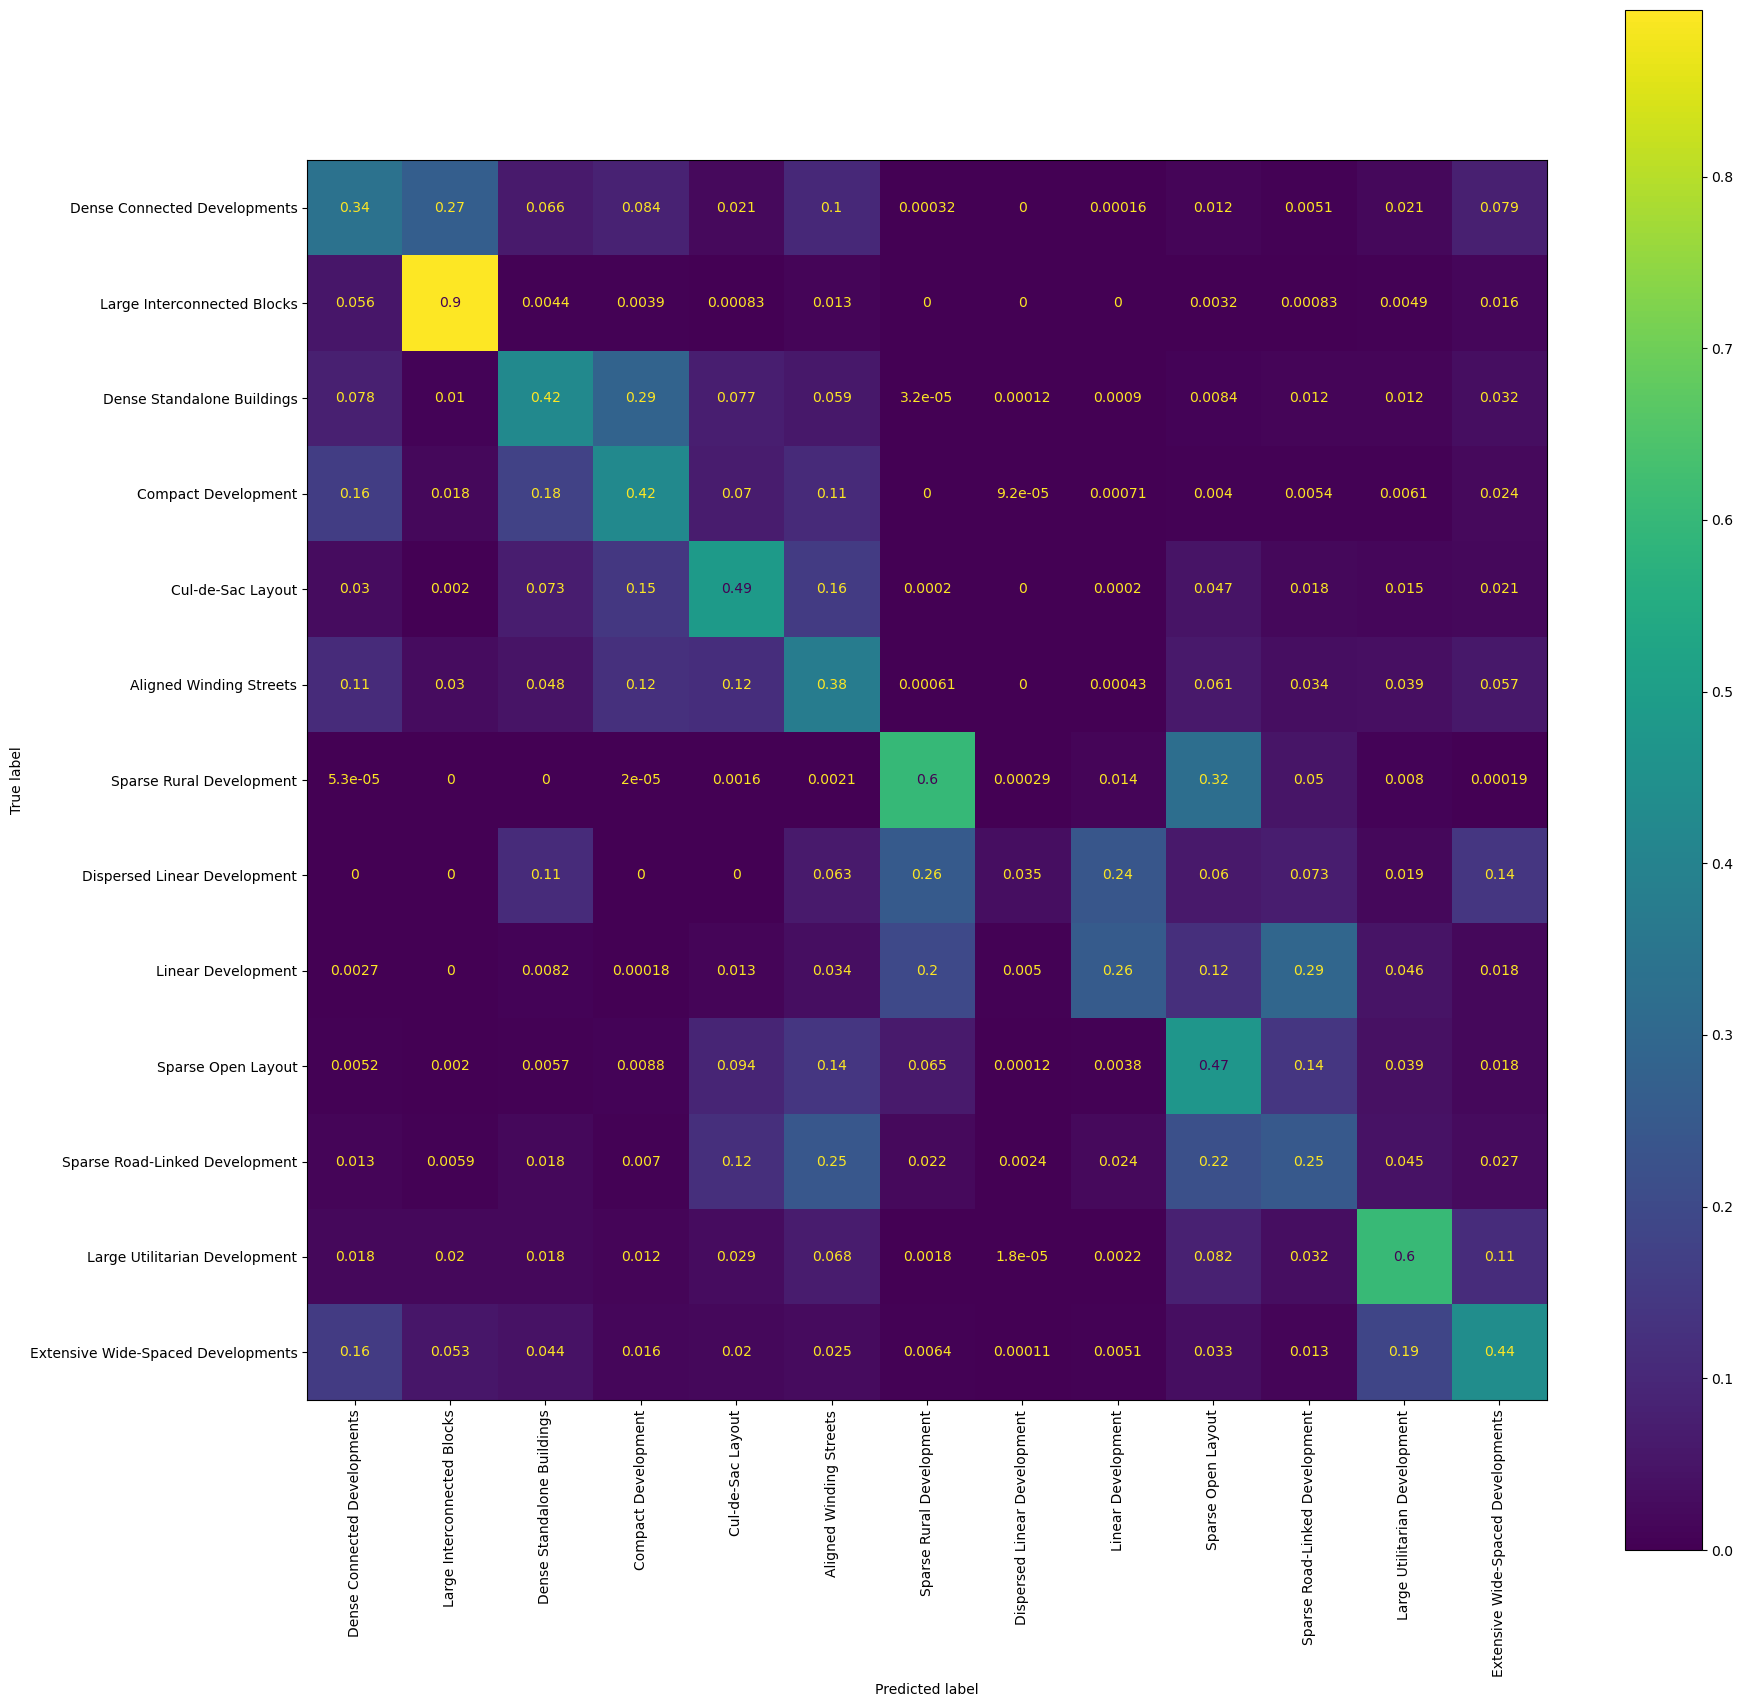

In [97]:
fig,ax = plt.subplots(figsize=(20,20))
disp.plot( xticks_rotation = 'vertical', ax=ax)

## All Scores

In [100]:
import glob
import pandas as pd


test_countries_names = ['Slovakia', 'Poland', 'Germany', 'Austria', 'Czechia']

mapping_level = 3

In [101]:
overall_accs = [pd.read_csv(f1fp).set_index('Unnamed: 0')['0'] for f1fp in sorted(glob.glob(f'/data/uscuni-eurofab/processed_data/results/overall_acc_{mapping_level}*'))]
overall_accs = pd.concat(overall_accs, axis=1)
overall_accs.index.name = ''
overall_accs.columns = test_countries_names
overall_accs

,Slovakia,Poland,Germany,Austria,Czechia
,,,,,
Overall accuracy,0.527079,0.554548,0.525852,0.589563,0.487259
Weighted F1,0.539785,0.559759,0.547672,0.612165,0.521370
Micro F1,0.527079,0.554548,0.525852,0.589563,0.487259
Macro F1,0.441375,0.518422,0.419451,0.483046,0.418075


In [53]:
f1s3 = [pd.read_csv(f1fp).set_index('Unnamed: 0')['0'] for f1fp in sorted(glob.glob(f'/data/uscuni-eurofab/processed_data/results/class_f1s_{mapping_level}*'))]
f1s3 = pd.concat(f1s3, axis=1)
f1s3.index.name = ''
f1s3.columns = test_countries_names
f1s3.sort_values('Austria')

,Slovakia,Poland,Germany,Austria,Czechia
,,,,,
Compact Development,0.172981,0.084837,0.295487,0.089964,0.071677
Dispersed Linear Development,0.249629,0.386398,0.233418,0.094352,0.194825
Linear Development,0.389734,0.412527,0.280766,0.163457,0.136729
Extensive Wide-Spaced Developments,0.227086,0.410615,0.079021,0.167235,0.241953
Sparse Road-Linked Development,0.401120,0.305645,0.283801,0.176619,0.170178
Aligned Winding Streets,0.304806,0.188761,0.324487,0.266017,0.163077
Large Interconnected Blocks,0.147011,0.116789,0.237069,0.283361,0.135922
Dense Connected Developments,0.216633,0.253915,0.375377,0.296466,0.249593
Large Utilitarian Development,0.216145,0.299314,0.261595,0.302493,0.304041


### Plot predictions

In [38]:
from lonboard import SolidPolygonLayer, Map
from lonboard.basemap import CartoBasemap
from lonboard.colormap import apply_categorical_cmap
from palettable.colorbrewer.qualitative import Set3_12
from core.cluster_validation import get_color

In [41]:
# regions_datadir = "/data/uscuni-eurofab-overture/"
# region_hulls = gpd.read_parquet(
#         regions_datadir + "regions/" + "ov_ce_region_hulls.parquet"
#     )
# region_hulls.explore()

In [42]:
region_id = 84986  # ms vienna
region_id = 84568  # ov vienna

In [44]:
buildings = gpd.read_parquet(f'/data/uscuni-eurofab-overture/processed_data/buildings/buildings_{region_id}.parquet')

In [45]:
region_vals = y_test.index.str.startswith(str(region_id))
labels = y_test[region_vals].final_without_noise
labels.index = labels.index.str.split('_').str[-1].astype(int)

In [46]:
buildings["predicted_label"] = pd.Series(mapped_predictions[region_vals], labels.index.values)
buildings["true_label"] = labels
# drop buildings that are in the ms data, but not in the cadastre
buildings = buildings.dropna()

In [47]:
# buildings = buildings[buildings.predicted_label != buildings.true_label]

In [48]:
layer = SolidPolygonLayer.from_geopandas(
    gdf=buildings[["geometry", "predicted_label", 'true_label']], get_fill_color=get_color(buildings['true_label'].values.astype(int)), opacity=0.15
)

/home/krasen/morphometrics/.pixi/envs/default/lib/python3.12/site-packages/lonboard/_geoarrow/ops/reproject.py:97: UserWarning: Input being reprojected to EPSG:4326 CRS
  warnings.warn("Input being reprojected to EPSG:4326 CRS")


In [49]:
m = Map(layer, basemap_style=CartoBasemap.DarkMatter)

In [50]:
from sidecar import Sidecar
sc = Sidecar(title='buildings')
with sc:
    display(m)

In [51]:
final_colors = get_color(np.arange(0, 20))

In [52]:
layer.get_fill_color = final_colors[buildings['predicted_label'].astype(int)]